In [1]:
%load_ext autoreload
%autoreload 2

# Standard libraries
from os.path import join

# Libraries for graphs
import community
import networkx as nx

# Libraries for matrix computations
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import numpy.matlib as matlib
import pandas as pd

# Libraries for sparse matrices and eigenvectors
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
from scipy.stats import hypergeom, pearsonr

# Import functions from nibna module
from nibna import build_graph_from_edge_list, build_node_importance_dataframe, compute_eigenvectors, compute_node_importance, compute_pearson_correlation, perform_community_detection

## Initialize constants

In [2]:
NUM_miR = 1719
NUM_mR = 20101
NUM_TF = 839

## Read Mes data

In [35]:
# Read Mes data and network
mes_df = pd.read_csv('../CancerDriver/Data/Output/EMT/Mes/pVal_cancer_data.csv')
mes_network = pd.read_csv('../CancerDriver/Data/Output/EMT/Mes/pVal_cancer_network.csv')

## Run NIBNA

In [36]:
mes_network = compute_pearson_correlation(mes_network, mes_df)

In [65]:
G_mes = build_graph_from_edge_list(mes_network, is_weighted=False)

In [66]:
len(G_mes.nodes())

7190

In [67]:
np.random.seed(10)
n_communities_mes = perform_community_detection(G_mes)

In [68]:
mes_adj_eigen_vectors = compute_eigenvectors(G_mes, n_communities_mes)

In [69]:
I_mes = compute_node_importance(G_mes.number_of_nodes(), n_communities_mes, np.real(mes_adj_eigen_vectors))
I_mes_df = build_node_importance_dataframe(G_mes, I_mes)

In [70]:
I_mes_df.head()

,node,importance
0,hsa-miR-27a-5p,0.012073
1,hsa-miR-103a-3p,0.011378
2,hsa-miR-92a-1-5p,0.011216
3,hsa-miR-23b-5p,0.011073
4,hsa-miR-19a-5p,0.010375


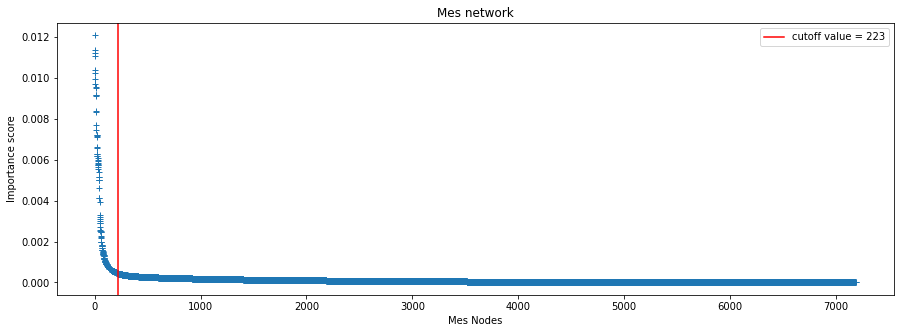

In [87]:
def compute_importance_score_threshold(importance_scores):  
    n_points = len(importance_scores)
    all_coord = np.vstack((range(n_points), importance_scores)).T
    np.array([range(n_points), importance_scores])
    
    first_point = all_coord[0]
    line_vec = all_coord[-1] - all_coord[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coord - first_point
    scalar_product = np.sum(vec_from_first * matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    dist_to_line = np.sqrt(np.sum(vec_to_line ** 2, axis=1))
    idx_of_best_point = np.argmax(dist_to_line)    
    return idx_of_best_point
    
cutoff_threshold_mes = compute_importance_score_threshold(I_mes_df.importance.values)

# Plot importance scores
rcParams['figure.figsize'] = 15, 5
plt.plot(np.sort(I_mes)[::-1], '+')
plt.xlabel('Mes Nodes')
plt.ylabel('Importance score')
plt.axvline(cutoff_threshold_mes, color='red', label='cutoff value = {0}'.format(cutoff_threshold_mes))
plt.legend(loc='upper right')
plt.title('Mes network')
plt.show()

In [72]:
mes_critical_nodes = pd.DataFrame(I_mes_df.node.iloc[:cutoff_threshold_mes])

In [73]:
mes_critical_nodes["Type"] = "coding"
mes_critical_nodes.loc[mes_critical_nodes.node.isin(mes_df.columns[:NUM_miR]), "Type"] = "non-coding"

In [74]:
mes_critical_nodes.Type.value_counts()

non-coding    118
coding        105
Name: Type, dtype: int64

## Load Coding gold standard data

In [75]:
coding_gold_standard_df = pd.read_csv('../CancerDriver/Data/Generic_EMT_signature.csv')
noncoding_gold_standard_mes_df = pd.read_csv('../CancerDriver/Data/Output/EMT/Mes/EMT_processed_miRNAs.csv')

In [76]:
coding_gold_standard_mes_df = coding_gold_standard_df.loc[coding_gold_standard_df.Epi=='Mes']

In [77]:
coding_gold_standard_mes_df.head()

,KRT19,Epi
144,GAS1,Mes
145,CXCL12,Mes
146,ZEB1,Mes
147,GLYR1,Mes
148,FHL1,Mes


In [78]:
validated_coding_candidate_drivers_mes = set(mes_critical_nodes.node[:100]).intersection(set(coding_gold_standard_mes_df.KRT19))
len(validated_coding_candidate_drivers_mes)

2

In [79]:
validated_noncoding_candidate_drivers_mes = set(mes_critical_nodes.node).intersection(noncoding_gold_standard_mes_df.V1)
len(validated_noncoding_candidate_drivers_mes)

25

In [80]:
validated_coding_candidate_drivers_mes

{'FLI1', 'FYN'}

In [86]:
validated_noncoding_candidate_drivers_mes, len(validated_noncoding_candidate_drivers_mes)

({'hsa-miR-100-5p',
  'hsa-miR-106b-5p',
  'hsa-miR-130a-5p',
  'hsa-miR-130b-5p',
  'hsa-miR-146a-5p',
  'hsa-miR-146b-5p',
  'hsa-miR-149-5p',
  'hsa-miR-155-5p',
  'hsa-miR-15b-5p',
  'hsa-miR-17-5p',
  'hsa-miR-181a-5p',
  'hsa-miR-182-5p',
  'hsa-miR-183-5p',
  'hsa-miR-191-5p',
  'hsa-miR-21-5p',
  'hsa-miR-221-5p',
  'hsa-miR-224-5p',
  'hsa-miR-23a-5p',
  'hsa-miR-29a-5p',
  'hsa-miR-375',
  'hsa-miR-452-5p',
  'hsa-miR-9-5p',
  'hsa-miR-92b-5p',
  'hsa-miR-93-5p',
  'hsa-miR-96-5p'},
 25)

In [82]:
top_20_coding_drivers = mes_critical_nodes.loc[mes_critical_nodes.Type=="coding"].node[:20].values
validated_coding_candidate_drivers_mes.intersection(set(top_20_coding_drivers))

{'FLI1', 'FYN'}

In [83]:
top_20_noncoding_drivers = mes_critical_nodes.loc[mes_critical_nodes.Type=="non-coding"].node[:20].values
validated_noncoding_candidate_drivers_mes.intersection(set(top_20_noncoding_drivers))

{'hsa-miR-17-5p', 'hsa-miR-182-5p', 'hsa-miR-23a-5p'}

## Compute p-values to get statistical significance

In [84]:
# Calculate p_value
# Coding
# Mes
n_A = (mes_critical_nodes.Type=="coding").sum() # number of estimated drivers
n_B = len(coding_gold_standard_mes_df) # number of signatures
n_C = 839+5168 # number of genes
n_A_B = len(validated_coding_candidate_drivers_mes) # number of drivers validated
p_value = 1 - hypergeom.cdf(n_A_B, n_C, n_B, n_A)
print("p_value for coding drivers of Mes: {0}".format(p_value))

p_value for coding drivers of Mes: 0.5754677967598723


In [85]:
n_A = (mes_critical_nodes.Type=="non-coding").sum() # number of estimated drivers
n_B = len(noncoding_gold_standard_mes_df) # number of signatures
n_C = 1719 # number of miRNA
n_A_B = len(validated_noncoding_candidate_drivers_mes) # number of drivers validated
p_value = 1 - hypergeom.cdf(n_A_B, n_C, n_B, n_A)
print("p_value for coding drivers of Mes: {0}".format(p_value))

p_value for coding drivers of Mes: 3.0145885787646876e-12
